Tutorial. How to do the following. 
- Sklearn Data Transformations
- MXNet Dataset and Dataloaders
- MXNet Custom Networks
- Training Base Model
- Extracting Embeddings from the Network
- Transfer Learning on a Different Dataset

## Imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# basic utils for data preparation, plotting
import os, sys, time, math, ast, re, string, random
from collections import defaultdict
import datetime
import joblib, boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import boto3
import gzip
import tarfile
from io import StringIO

# mxnet/gluon/gluonnlp 
import mxnet as mx
from mxnet import gluon, autograd
import mxnet.ndarray as nd
import gluonnlp as nlp

# sklearn ML stuff
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import normalize

# For creating sklearn transformers
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

# For t-SNE
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors

## Loading and Splitting Data 

Data sources: 
1. Hotel reviews data - https://www.kaggle.com/harmanpreet93/hotelreviews
2. IMDB reviews data - https://www.kaggle.com/jcblaise/imdb-sentiments#train.csv

We will train the neural net on IMDB reviews data and use the learnt embeddings from different layers of neural net as features for classifying Hotel reviews. We will then calculate how much lift it gives to the baseline Hotel model which doesn't use these embeddings. 

For IMDB, 0 means positive label.     
For Hotel, happy means positive label

### Loading

In [3]:
imdb = pd.read_csv("data/imdb.csv")
hotel = pd.read_csv("data/hotel-reviews.csv")

In [4]:
imdb.shape, hotel.shape

((25000, 2), (38932, 5))

In [5]:
imdb.head(3)

,text,sentiment
0,For a movie that gets no respect there sure ar...,0
1,Bizarre horror movie filled with famous faces ...,0
2,"A solid, if unremarkable film. Matthau, as Ein...",0


In [6]:
# 0 is positive for imdb, making it same for hotel
hotel["Is_Response"] = pd.Series(hotel["Is_Response"]!="happy").astype(int)

In [7]:
hotel.head(3)

,User_ID,Description,Browser_Used,Device_Used,Is_Response
0,id10326,The room was kind of clean but had a VERY stro...,Edge,Mobile,1
1,id10327,I stayed at the Crown Plaza April -- - April -...,Internet Explorer,Mobile,1
2,id10328,I booked this hotel through Hotwire at the low...,Mozilla,Tablet,1


Ratio of positive to negative labels

In [8]:
sum(hotel.Is_Response==0)/hotel.shape[0]*100

68.12133977190999

In [9]:
sum(imdb.sentiment==0)/imdb.shape[0]*100

50.0

In [10]:
# pd.set_option('display.max_colwidth', -1)  

### Train valid test split

In [11]:
imdb_X_train, imdb_X_test, imdb_y_train, imdb_y_test = train_test_split(imdb["text"],
                                                                    imdb["sentiment"],
                                                                    test_size=0.20,
                                                                    random_state=1)

In [12]:
# 20% for train for validation
imdb_X_train, imdb_X_valid, imdb_y_train, imdb_y_valid = train_test_split(imdb_X_train,
                                                                    imdb_y_train,
                                                                    test_size=0.20,
                                                                    random_state=1)  

In [13]:
assert imdb_X_train.shape[0] + imdb_X_valid.shape[0] + imdb_X_test.shape[0] == imdb.shape[0]

In [14]:
imdb_X_train.shape

(16000,)

In [15]:
hotel_X_train, hotel_X_test, hotel_y_train, hotel_y_test = train_test_split(hotel["Description"],
                                                                    hotel["Is_Response"],
                                                                    test_size=0.20,
                                                                    random_state=1)

In [16]:
hotel_X_train, hotel_X_valid, hotel_y_train, hotel_y_valid = train_test_split(hotel_X_train,
                                                                    hotel_y_train,
                                                                    test_size=0.20,
                                                                    random_state=1)

In [17]:
assert hotel_X_train.shape[0] + hotel_X_valid.shape[0] + hotel_X_test.shape[0] == hotel.shape[0]

## Sklearn Data Transformations

In [18]:
class Tokenize(BaseEstimator, TransformerMixin):
    """
    Takes in pandas series and applies tokenization on each row based on given split pattern. 
    """
    def __init__(self, split_pat=f"([{string.punctuation}])"):
        self.split_pat = split_pat  # re pattern used to split string to tokens. default splits over any string punctuation
    
    def tokenize(self, s):
        """ Tokenize string """
        re_tok = re.compile(self.split_pat)
        return re_tok.sub(r' \1 ', s).split()  # substitute all delimiters specified in pattern with space and then splits over space
    
    def fit(self, X, y=None):  # no need to learn anything from training data for tokenization. so returning self
        return self

    def transform(self, X, y=None):
        return X.apply(self.tokenize)
    
    
class Tok2Idx(BaseEstimator, TransformerMixin):
    """
    Creates integer index from tokenizes columns. 
    Creates a dictionary of all unique tokens and corresponding integer index
    Transform maps any token unseen in the training data to <unk> token 
    Need pandas series as input. 
    """
            
    def map_tok_idx(self, char):
        try:
            return self.tok2idx[char]
        except KeyError:
            return self.tok2idx["<unk>"]

    def fit(self, X, y=None):
        """ To be called for training data. Creates a token to integer map """
        self.uniq_set = list(set([y for x in list(X.values) for y in x]))
        self.uniq_set.append("<unk>")
        self.tok2idx = {j:i for i,j in enumerate(self.uniq_set)}
        self.idx2tok = {i:j for i,j in enumerate(self.uniq_set)}
        return self

    def transform(self, X, y=None):
        return X.map(lambda x: [self.map_tok_idx(c) for c in x])
    
    
class LowerCaser(BaseEstimator, TransformerMixin):
    """
    Lower case all string values
    Need pandas series as input. 
    """
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X.str.lower()
    
    
class NullImputer(SimpleImputer):
    """
    SimpleImputer works with 2D array. For the purpose of this analysis, we are working with pd Series. 
    Modifying it a bit
    """
    def __init__(self, missing_values=np.nan, strategy='mean', fill_value=None, **kw):
        super(NullImputer, self).__init__(
            missing_values=missing_values,
            strategy=strategy,
            fill_value=fill_value
        )

    def fit(self, X, y=None):
        super(NullImputer, self).fit(pd.DataFrame(X), y)
        return self

    def transform(self, X):
        result = super(NullImputer, self).transform(pd.DataFrame(X))
        return pd.DataFrame(result)[0]  # converting 2D array back to series

In [19]:
transformer = Pipeline(steps=[
    ("null_impute", NullImputer(strategy="constant", fill_value="null")),
    ("lower_case", LowerCaser()),
    ("tokenize", Tokenize()),
    ("token2index", Tok2Idx())
])

In [20]:
imdb_X_train_transformed = transformer.fit_transform(imdb_X_train)
imdb_X_valid_transformed = transformer.transform(imdb_X_valid)
imdb_X_test_transformed = transformer.transform(imdb_X_test)

In [21]:
# let's see how it's working
transformer.transform(pd.Series(["This is just an example.",
                                "This is another example"]))

0    [25405, 909, 37236, 52086, 42321, 40316]
1                  [25405, 909, 23001, 42321]
Name: 0, dtype: object

In [22]:
# total tokens
tt = transformer.named_steps['token2index']

In [23]:
# unknown token
tt.tok2idx['<unk>']  

63166

## MXNet Dataset and Dataloaders

In [24]:
def get_dataset(review_array, labels_array, max_seq_len=20):

    dataset = gluon.data.SimpleDataset(list(zip(review_array,
                                                labels_array))).\
        transform(lambda review, label: (
            nlp.data.ClipSequence(max_seq_len)(review), label))
    return dataset


def get_dataloader(dataset,
                   dataset_type="train",  # valid/test
                   batch_size=256,
                   bucket_num=5,
                   shuffle=True,  # true for training
                   num_workers=1):
    
    # Batchify function appends the length of each sequence to feed as addtional input 
    combined_batchify_fn = nlp.data.batchify.Tuple(
        nlp.data.batchify.Pad(axis=0, ret_length=True),
        nlp.data.batchify.Stack(dtype='float32'))  # stack input samples
  
    if dataset_type == "train":
        data_lengths = dataset.transform(
            lambda review, label: float(len(review)), lazy=False)
    
        # We need to shuffle for training data.
        # It's more efficient to shuffle training data such that sequences with similar length come together
        # This is achieved using FixedBucketSampler
        batch_sampler = nlp.data.sampler.FixedBucketSampler(
            data_lengths,
            batch_size=batch_size,
            num_buckets=bucket_num,
            shuffle=shuffle)

        dataloader = gluon.data.DataLoader(
            dataset=dataset,
            batch_sampler=batch_sampler,
            batchify_fn=combined_batchify_fn,
            num_workers=num_workers,
        )
    # No bucketing or shuffling is performed for valid and test
    elif dataset_type in ["valid", "test"]:
        batch_sampler = None
        dataloader = gluon.data.DataLoader(
            dataset=dataset,
            shuffle=shuffle,
            batch_size=batch_size,
            batchify_fn=combined_batchify_fn,
            num_workers=num_workers)
    else:
        raise Exception("Pass dataset type from train, dev, valid or test")

    return dataloader

In [25]:
# 90th percentile of review length. We use this to clip the LSTM sequence to max of this length
clip_val = np.percentile(imdb_X_train_transformed.apply(lambda x: len(x)).values, 90)
clip_val

555.0

In [26]:
max_len=int(clip_val)

In [27]:
imdb_train_dataset = get_dataset(imdb_X_train_transformed.values, 
                                  imdb_y_train.values,
                                  max_len)
imdb_valid_dataset = get_dataset(imdb_X_valid_transformed.values, 
                                  imdb_y_valid.values,
                                  max_len)
imdb_test_dataset = get_dataset(imdb_X_test_transformed.values, 
                                  imdb_y_test.values,
                                  max_len)

In [28]:
len(imdb_train_dataset)

16000

In [29]:
print("Sequence: ", imdb_train_dataset[0][0][:5])
print("Sentiment: ", imdb_train_dataset[0][1])

Sequence:  [17276, 4747, 31258, 52086, 12922]
Sentiment:  0


In [30]:
len(imdb_train_dataset)

16000

In [31]:
imdb_train_dataloader = get_dataloader(imdb_train_dataset,
                                       batch_size=64,
                                       bucket_num=5,
                                       shuffle=True,
                                       num_workers=0,
                                       dataset_type="train",)

imdb_valid_dataloader = get_dataloader(imdb_valid_dataset,
                                       batch_size=64,
                                       bucket_num=5,
                                       shuffle=False,
                                       num_workers=0,
                                       dataset_type="valid")

imdb_test_dataloader = get_dataloader(imdb_test_dataset,
                                      batch_size=64,
                                      bucket_num=5,
                                      shuffle=False,
                                      num_workers=0,
                                      dataset_type="test")

In [32]:
next(iter(imdb_valid_dataloader))

((
  [[31876. 12660.  3825. ...     0.     0.     0.]
   [55342. 17276. 32304. ...     0.     0.     0.]
   [62462. 18475. 10281. ...     0.     0.     0.]
   ...
   [10259. 52466. 40934. ...     0.     0.     0.]
   [18894. 40934. 33774. ...     0.     0.     0.]
   [25405. 52875. 18894. ...     0.     0.     0.]]
  <NDArray 64x555 @cpu_shared(0)>,
  
  [256 268  71  89 364 142 144 152 555 189  51 125 555 261 139 109 501 555
   149 313 240 321 189 479 351 225 555 265 172 161 163 197 555 142 325 192
   179 176 555 318 204  58 163 555 223 143  42 217 186 555 151 183  72  94
   106 135 273 161 280 152 555  72 169 151]
  <NDArray 64 @cpu_shared(0)>),
 
 [0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0.
  0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 0. 1.
  1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
 <NDArray 64 @cpu_shared(0)>)

## Defining MXNet Network

In [33]:
class CustomSeqNet(gluon.nn.HybridBlock):
    """
    Custom defined network for sequence data that is used to predict a binary label.   
    
    """
    def __init__(self, input_output_embed_map, dense_sizes=[100], dropouts=[0.2], activation="relu"):
        """
        input_output_embed_map: {"token_embed": (max_tok_idx, tok_embed_dim), "hidden_embed": (,hidden_embed_dim))}
        """
        self.dense_sizes = dense_sizes  # list of output dimension of dense layers
        self.dropouts = dropouts  # list of dropout for each dense layer

        super(CustomSeqNet, self).__init__(prefix='CustomSeqNet_')

        with self.name_scope():  # name space object to manage parameter names
            # 1. Embedding layer
            self.embed = gluon.nn.Embedding(
                input_dim=input_output_embed_map["token_embed"][0],
                output_dim=input_output_embed_map["token_embed"][1],
                prefix='token_embed_'
            )  # output = (bs, sequence_len, input_size) = (N,T,C)
            
            # 2. GRU layer
            self.rnn = gluon.rnn.GRU(
                hidden_size=input_output_embed_map["hidden_embed"][1],
                bidirectional=True, 
                layout='NTC', # batch size, sequence length and feature dimensions respectively
                prefix='review_gru_'
            ) 

            # 3. Dense layers
            # need to specify in_units in Dense for some initialization issues
            for i, sz in enumerate(self.dense_sizes):
                setattr(self, "dense_{}".format(i), gluon.nn.Dense(sz))
                setattr(self, "bn_dense_{}".format(
                    i), gluon.nn.BatchNorm(axis=1))
                setattr(self, "activation_dense_{}".format(
                    i), gluon.nn.Activation(activation))
                setattr(self, "drop_dense_{}".format(i),
                        gluon.nn.Dropout(self.dropouts[i]))
            # 4. Output layer
            self.output = gluon.nn.Dense(1, prefix="output_")

    def hybrid_forward(self, F, review, review_len):
        embed = self.embed(review) # 1
        rnn_all = self.rnn(embed) # 2
        # Extract last output in sequence
        net = F.SequenceLast(rnn_all, sequence_length=F.cast(
            review_len, 'float32'), use_sequence_length=True, axis=1)  # use review_len to remove the paddings
        for i, sz in enumerate(self.dense_sizes): # 3
            net = getattr(self, "dense_{}".format(i))(net)  # MLP
            net = getattr(self, "bn_dense_{}".format(i))(net)  # BN
            net = getattr(self, "activation_dense_{}".format(i))(net)  # relu
            net = getattr(self, "drop_dense_{}".format(i))(net)  # dropouts
        net = self.output(net) # 4
        return net

In [34]:
ctx = [mx.gpu(0)]  # use GPU

In [35]:
max_idx = max(tt.tok2idx.values())+1  # starts from 0
max_idx

63167

In [36]:
tok_embed_dim = 64
review_embed_dim = 50  # embedding size of hidden state in GRU

input_output_embed_map = {"token_embed": (max_idx, tok_embed_dim),
                         "hidden_embed": (None, review_embed_dim)}

In [80]:
input_output_embed_map

{'token_embed': (63167, 64), 'hidden_embed': (None, 50)}

In [81]:
dropouts = [0.2, 0.2, 0.2]
dense_sizes=[100, 100, 10]
activation="relu"

In [82]:
net1 = CustomSeqNet(input_output_embed_map, dense_sizes, dropouts, activation)

In [83]:
net1.initialize(mx.init.Xavier(), ctx=ctx, force_reinit=True)  # initialize network

In [84]:
# net1.hybridize()

In [85]:
# net1.forward(next(iter(imdb_train_dataloader))[0][0].as_in_context(ctx[0]), 
#              next(iter(imdb_train_dataloader))[0][1].as_in_context(ctx[0]))

## Training Base Model

In [86]:
def evaluate_network(network, loss, data_iterator, ctx, calculate_metrics=True):
    loss_acc = 0.
    y_true = np.array([])
    y_hat = np.array([])
    for idx, ((data, length), label) in enumerate(data_iterator):
        X_ = gluon.utils.split_and_load(data, ctx, even_split=False)  # splits data to go to each gpu
        X_l_ = gluon.utils.split_and_load(length, ctx, even_split=False)
        y_ = gluon.utils.split_and_load(label, ctx, even_split=False)
        y_true = np.concatenate([y_true] + [y_i.asnumpy() for y_i in y_])  # get all in one big list
        preds = [network(x_, x_l_) for x_, x_l_ in zip(X_, X_l_)]
        y_hat = np.concatenate([y_hat] + [p.asnumpy().flatten() for p in preds]) # get all in one big list
        if calculate_metrics:
            losses = [loss(p, y) for p, y in zip(preds, y_)]  
            loss_acc += sum(losses).mean() / len(ctx)
    if calculate_metrics: 
        auc = roc_auc_score(y_true, y_hat)
    else:
        return y_true, y_hat
    return loss_acc.asnumpy()[0]/float(idx+1), auc, y_true, y_hat

In [92]:
def train(network, 
          train_data, 
          holdout_data, 
          loss,
          epochs, 
          ctx, 
          lr=1e-2,
          wd=1e-5,
          optimizer='adam'):
    
    # 1. Define optimizer
    trainer = gluon.Trainer(network.collect_params(), optimizer,
                            {'learning_rate': lr, 'wd': wd})
    
    # Hybridize network for faster computations. (Symbolic)
    network.hybridize()
    
    # Print loss values before training starts
    valid_loss, valid_auc, _, _ = evaluate_network(network, loss, holdout_data, ctx)
    train_loss, train_auc, _, _ = evaluate_network(network, loss, train_data, ctx)

    print("Start \n Training BCE {:.4f}, Train AUC {:.4f}, Valid AUC {:.4f}".format(train_loss,
                                                                                    train_auc,
                                                                                    valid_auc))
    
    # 3. Train the network
    for e in range(epochs):
        for idx, ((data, length), label) in enumerate(train_data):  # For each mini batch
            X_ = gluon.utils.split_and_load(data, ctx, even_split=False)  # splits data to go to each gpu
            X_l_ = gluon.utils.split_and_load(length, ctx, even_split=False)
            y_ = gluon.utils.split_and_load(label, ctx, even_split=False)
            
            # Forward pass to be done in .record() mode. 
            # By default, record mode takes it to training mode and helps with layers like dropout which
            # require different treatment for predict model
            with autograd.record():
                preds = [network(x_, x_l_) for x_, x_l_ in zip(X_, X_l_)]  # forward pass
                losses = [loss(p, y) for p, y in zip(preds, y_)]  # loss calculation

            [k.backward() for k in losses]  # gradient calculation using chain rule
            trainer.step(data.shape[0])  # performs one step of gradient descent. input parameter is # rows in mini batch

        valid_loss, valid_auc, _, _ = evaluate_network(network, loss, holdout_data, ctx)
        train_loss, train_auc, _, _ = evaluate_network(network, loss, train_data, ctx)

        print("Epoch [{}], Training BCE {:.4f}, Train AUC {:.4f}, Valid AUC {:.4f}".format(e+1, 
                                                                                           train_loss,
                                                                                           train_auc,
                                                                                           valid_auc))

Using the defined function to train the network 

In [93]:
optimizer = 'adam'
wd = 3e-4
lr=1e-2
ctx = [mx.gpu(0)]
loss = gluon.loss.SigmoidBCELoss()  # define the loss fn

In [94]:
epochs=7
total_iterations = len(imdb_train_dataloader)*epochs
total_iterations

1764

In [95]:
%%time
net1.initialize(mx.init.Xavier(), ctx=ctx, force_reinit=True)

train(
    net1, 
    imdb_train_dataloader, 
    imdb_valid_dataloader,
    loss,
    epochs=5, 
    lr=lr,
    wd=wd, 
    optimizer=optimizer, 
    ctx=ctx)

Start 
 Training BCE 0.6931, Train AUC 0.5059, Valid AUC 0.5028
Epoch [1], Training BCE 1.6850, Train AUC 0.9445, Valid AUC 0.9217
Epoch [2], Training BCE 0.2190, Train AUC 0.9731, Valid AUC 0.9498
Epoch [3], Training BCE 0.2420, Train AUC 0.9755, Valid AUC 0.9490
Epoch [4], Training BCE 0.2663, Train AUC 0.9790, Valid AUC 0.9483
Epoch [5], Training BCE 0.1998, Train AUC 0.9865, Valid AUC 0.9507
CPU times: user 1min 58s, sys: 21 s, total: 2min 19s
Wall time: 2min 1s


Train some more with reduced learning rate

In [96]:
%%time

train(
    net1, 
    imdb_train_dataloader, 
    imdb_valid_dataloader,
    loss,
    epochs=1, 
    lr=lr/10,
    wd=wd, 
    optimizer=optimizer, 
    ctx=ctx)

Start 
 Training BCE 0.2007, Train AUC 0.9865, Valid AUC 0.9507
Epoch [1], Training BCE 0.0978, Train AUC 0.9940, Valid AUC 0.9563
CPU times: user 29 s, sys: 4.5 s, total: 33.5 s
Wall time: 30.1 s


In [97]:
_, _, y_valid, hat_valid = evaluate_network(net1, 
                                            loss,
                                            imdb_valid_dataloader,
                                            ctx)
roc_auc_score(y_valid, hat_valid) 

0.9562818647077602

In [98]:
_, _, y_test, hat_test = evaluate_network(net1, 
                                          loss,
                                          imdb_test_dataloader,
                                          ctx)
roc_auc_score(y_test, hat_test) 

0.9518646542216113

We get >95% auc on the test test. So the model has learnt well. Let's see how the score distribution looks like

In [99]:
def sigmoid(x, derivative=False):
    sigm = 1. / (1. + np.exp(-x))
    if derivative:
        return sigm * (1. - sigm)
    return sigm

In [100]:
sigmoid_v = np.vectorize(sigmoid)

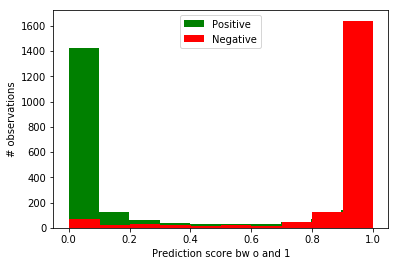

In [101]:
h=plt.hist(sigmoid_v(hat_valid[y_valid==0]), color='g')
h=plt.hist(sigmoid_v(hat_valid[y_valid==1]), color='r')
plt.xlabel("Prediction score bw o and 1")
plt.ylabel("# observations")
plt.legend(["Positive", 'Negative'])

In [102]:
# saving the network
net1.export(os.path.join("models", "imdb_v2"), epoch=0) 

## TSNE

### Token embeddings

In [103]:
tok_embed = net1.embed.weight.list_data()[0].asnumpy()  # extract weights of embedding layer from network
tok_embed.shape

(63167, 64)

In [104]:
few_words = ['great', 'excellent', 'best', 'perfect', 'wonderful', 'well',
       'fun', 'love', 'amazing', 'also', 'enjoyed', 'favorite', 'it',
       'and', 'loved', 'highly', 'bit', 'job', 'today', 'beautiful',
       'you', 'definitely', 'superb', 'brilliant', 'world', 'liked',
       'still', 'enjoy', 'life', 'very', 'especially', 'see', 'fantastic',
       'both', 'shows', 'good', 'may', 'terrific', 'heart', 'classic',
       'will', 'enjoyable', 'beautifully', 'always', 'true', 'perfectly',
       'surprised', 'think', 'outstanding', 'most',
             
       'bad', 'worst', 'awful', 'waste', 'boring', 'poor', 'terrible',
       'no', 'nothing', 'poorly', 'dull', 'horrible', 'script', 'stupid',
       'worse', 'even', 'minutes', 'instead', 'fails', 'unfortunately',
       'just', 'annoying', 'ridiculous', 'plot', 'money', 'supposed',
       'avoid', 'mess', 'disappointing', 'disappointment', 'lame', 'crap',
       'predictable', 'any', 'pointless', 'weak', 'badly', 'not', 'only',
       'unless', 'looks', 'why', 'wasted', 'save', 'oh', 'attempt',
       'problem', 'acting', 'lacks', 'seems']

In [105]:
len(few_words)

100

Plotting TSNE of 100 words 

In [106]:
tok_trans = transformer.named_steps['token2index']
tok_embed_sub = tok_embed[[tok_trans.tok2idx[i] for i in few_words]]
tok_embed_sub.shape

(100, 64)

In [107]:
tsne = TSNE(perplexity=40, n_iter=1000,)
Y_char = tsne.fit_transform(tok_embed_sub)

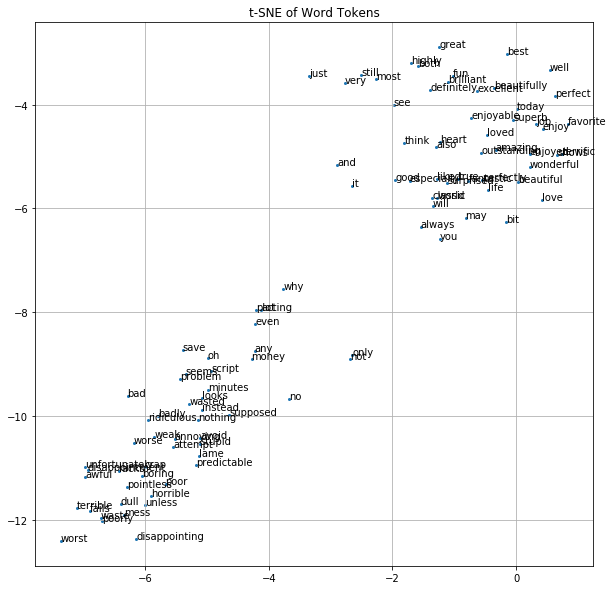

In [108]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(x=Y_char[:,0], y=Y_char[:,1], s=4)
ax.grid()

for i in range(Y_char.shape[0]):
    txt = few_words[i]
    ax.annotate(txt, (Y_char[i,0], Y_char[i,1]), fontsize=10)    
_ = ax.set_title('t-SNE of Word Tokens')

## Transfer Learning on a Different Dataset

In [148]:
def load_base_model(model_path, epoch, ctx, layer_name=None, n_inputs=2):
    """ Loads the model from given model path 
        and returns a subnetwork that gives output from layer_name 
    """
    xfer_net = gluon.nn.SymbolBlock.imports(
        model_path + "-symbol.json",
        ['data%i' % i for i in range(n_inputs)],
        model_path + "-%.4d.params" % epoch,
        ctx=ctx,
    )
    inputs = [mx.sym.var(('data%i')% i) for i in range(n_inputs)]
    output = xfer_net(*inputs)
    print(output.get_internals())
    outputs = output.get_internals()[layer_name]
    return gluon.SymbolBlock(outputs, inputs, params=xfer_net.collect_params())

In [149]:
def get_embeddings(layer_name, ctx, X, y, max_seq_len):
    
    net = load_base_model(pretrained_model_path, 0, ctx, layer_name=layer_name, n_inputs=2)
    loss = loss = gluon.loss.SigmoidBCELoss()  
    
    dataset = get_dataset(X, y, max_seq_len)
    dataloader = get_dataloader(dataset, 
                                dataset_type='valid', 
                                batch_size=256, 
                                shuffle=False)
    y, yhat = evaluate_network(net, loss, dataloader, ctx, calculate_metrics=False)
    yhat = yhat.reshape(y.shape[0], int(yhat.shape[0]/y.shape[0]))
    return y, yhat

### Weights as it is

In [111]:
hotel_X_transformed = transformer.transform(hotel_X_test)

In [112]:
hotel_X_transformed.head()

0    [28865, 43121, 40934, 34486, 24519, 40316, 254...
1    [15347, 14751, 13343, 36401, 37175, 35196, 511...
2    [17276, 35406, 25308, 35131, 18693, 56304, 351...
3    [38162, 25922, 32604, 17276, 25308, 61502, 279...
4    [25405, 63166, 18894, 37236, 60787, 32604, 489...
Name: 0, dtype: object

In [113]:
pretrained_model_path = 'models/imdb_v2'

In [150]:
hotel_y, hotel_yhat = get_embeddings("CustomSeqNet_output_fwd_output",  # name of final layer
                                     ctx,
                                     hotel_X_transformed.values, 
                                     hotel_y_test,
                                     max_len)

<Symbol group [data0, CustomSeqNet_token_embed_weight, CustomSeqNet_token_embed_fwd, CustomSeqNet_review_gru_swapaxes0, CustomSeqNet_review_gru_l0_i2h_weight, CustomSeqNet_review_gru_reshape0, CustomSeqNet_review_gru_l0_h2h_weight, CustomSeqNet_review_gru_reshape1, CustomSeqNet_review_gru_r0_i2h_weight, CustomSeqNet_review_gru_reshape2, CustomSeqNet_review_gru_r0_h2h_weight, CustomSeqNet_review_gru_reshape3, CustomSeqNet_review_gru_l0_i2h_bias, CustomSeqNet_review_gru_reshape4, CustomSeqNet_review_gru_l0_h2h_bias, CustomSeqNet_review_gru_reshape5, CustomSeqNet_review_gru_r0_i2h_bias, CustomSeqNet_review_gru_reshape6, CustomSeqNet_review_gru_r0_h2h_bias, CustomSeqNet_review_gru_reshape7, CustomSeqNet_review_gru__rnn_param_concat0, CustomSeqNet_CustomSeqNet_review_gru_h0_0, CustomSeqNet_review_gru_rnn0, CustomSeqNet_review_gru_rnn0, CustomSeqNet_review_gru_swapaxes1, data1, CustomSeqNet_cast0, CustomSeqNet_sequencelast0, CustomSeqNet_dense0_weight, CustomSeqNet_dense0_bias, CustomSeqNet_

In [143]:
roc_auc_score(hotel_y, hotel_yhat)

0.8572269034747125

So without even training any on the hotel reviews dataset, we able to infer and get an AUC of 85% using the model trained on movie reviews dataset. Pretty good!

### Weights as feature extractor
Using Catboost

In [116]:
# catboost
from catboost import CatBoostClassifier, Pool

In [117]:
y, X = get_embeddings("CustomSeqNet_sequencelast0_output", 
                      ctx,
                     transformer.transform(hotel_X_train).values, 
                     hotel_y_train,
                     max_len)
train_dataset = Pool(X,
                    y)

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/gluon/block.py:1159: UserWarning: Cannot decide type for the following arguments. Consider providing them as input:
	data0: None
  input_sym_arg_type = in_param.infer_type()[0]


In [118]:
y, X = get_embeddings("CustomSeqNet_sequencelast0_output", 
                      ctx,
                    transformer.transform(hotel_X_valid).values, 
                    hotel_y_valid,
                    max_len)
valid_dataset = Pool(X,
                    y)

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/gluon/block.py:1159: UserWarning: Cannot decide type for the following arguments. Consider providing them as input:
	data0: None
  input_sym_arg_type = in_param.infer_type()[0]


In [119]:
y, X = get_embeddings("CustomSeqNet_sequencelast0_output", 
                      ctx,
                      transformer.transform(hotel_X_test).values, 
                      hotel_y_test,
                      max_len)
test_dataset = Pool(X,
                    y)

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/gluon/block.py:1159: UserWarning: Cannot decide type for the following arguments. Consider providing them as input:
	data0: None
  input_sym_arg_type = in_param.infer_type()[0]


In [120]:
# Initialize CatBoostClassifier
model = CatBoostClassifier(random_state=10, 
                           early_stopping_rounds=50, 
                           task_type='GPU',
                           devices="0"
                          )

model.fit(train_dataset,
          use_best_model=True,
          eval_set=valid_dataset, 
          verbose=False,
          plot=True)
print("Count of trees in model = {}".format(model.tree_count_))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Count of trees in model = 115


In [121]:
roc_auc_score(test_dataset.get_label(), 
              model.predict_proba(test_dataset)[:,1])

0.8622846987738766

Nice, we get a little bit better than just using the scores from pre-trained model. (86% vs 85% AUC). 
Below are the results on Hotel reviews data (33% happy) if we use different layers as feature extractor. We can see that the inner layers (which have more generic representations perform better as features for catboost model)
- sequencelast0 = 86.09
- dense0 = 85.87
- dense1 = 85.32
- dense2 = 85.05
- output = 85.01
- generic - 85.01 (directly using scores)

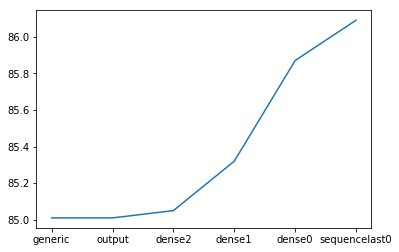

In [122]:
plt.plot(['generic', 'output', 'dense2', 'dense1', 'dense0', 'sequencelast0'],
        [85.01, 85.01, 85.05, 85.32, 85.87, 86.09])

### Weights as initializations

In [139]:
net1.summary

<bound method Block.summary of CustomSeqNet(
  (embed): Embedding(63167 -> 64, float32)
  (rnn): GRU(64 -> 50, NTC, bidirectional)
  (dense_0): Dense(100 -> 100, linear)
  (bn_dense_0): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=100)
  (activation_dense_0): Activation(relu)
  (drop_dense_0): Dropout(p = 0.2, axes=())
  (dense_1): Dense(100 -> 100, linear)
  (bn_dense_1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=100)
  (activation_dense_1): Activation(relu)
  (drop_dense_1): Dropout(p = 0.2, axes=())
  (dense_2): Dense(100 -> 10, linear)
  (bn_dense_2): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=10)
  (activation_dense_2): Activation(relu)
  (drop_dense_2): Dropout(p = 0.2, axes=())
  (output): Dense(10 -> 1, linear)
)>

In [123]:
net1.collect_params()

CustomSeqNet_ (
  Parameter CustomSeqNet_token_embed_weight (shape=(63167, 64), dtype=float32)
  Parameter CustomSeqNet_review_gru_l0_i2h_weight (shape=(150, 64), dtype=float32)
  Parameter CustomSeqNet_review_gru_l0_h2h_weight (shape=(150, 50), dtype=float32)
  Parameter CustomSeqNet_review_gru_l0_i2h_bias (shape=(150,), dtype=float32)
  Parameter CustomSeqNet_review_gru_l0_h2h_bias (shape=(150,), dtype=float32)
  Parameter CustomSeqNet_review_gru_r0_i2h_weight (shape=(150, 64), dtype=float32)
  Parameter CustomSeqNet_review_gru_r0_h2h_weight (shape=(150, 50), dtype=float32)
  Parameter CustomSeqNet_review_gru_r0_i2h_bias (shape=(150,), dtype=float32)
  Parameter CustomSeqNet_review_gru_r0_h2h_bias (shape=(150,), dtype=float32)
  Parameter CustomSeqNet_dense0_weight (shape=(100, 100), dtype=float32)
  Parameter CustomSeqNet_dense0_bias (shape=(100,), dtype=float32)
  Parameter CustomSeqNet_batchnorm0_gamma (shape=(100,), dtype=<class 'numpy.float32'>)
  Parameter CustomSeqNet_batchnor

In [124]:
# Check results
# print(trainer.network.collect_params('.*email_alias'))  # index
# print(list(net1.collect_params('.*review|.*emb').values())[0].data())
# print(list(net1.collect_params('.*dense').values())[0].data())


In [125]:
# Freeze layers except last dense layer
for param in net1.collect_params('.*review|.*emb').values():
    param.grad_req = 'null'

In [126]:
dataset = get_dataset(transformer.transform(hotel_X_train), 
                      hotel_y_train,
                      max_len)
hotel_train_dataloader = get_dataloader(dataset, 
                            batch_size=64, 
                            bucket_num=5,
                            shuffle=False, 
                            num_workers=0)

In [127]:
dataset = get_dataset(transformer.transform(hotel_X_valid), 
                      hotel_y_valid,
                      max_len)
hotel_valid_dataloader = get_dataloader(dataset, 
                            batch_size=64, 
                            bucket_num=5,
                            shuffle=False, 
                            num_workers=0)

In [128]:
dataset = get_dataset(transformer.transform(hotel_X_test), 
                      hotel_y_test,
                      max_len)
hotel_test_dataloader = get_dataloader(dataset, 
                            batch_size=64, 
                            bucket_num=5,
                            shuffle=False, 
                            num_workers=0)

In [129]:
%%time
train(
    net1, 
    hotel_train_dataloader,
    hotel_valid_dataloader,
    loss,
    epochs=3,
    lr=1e-2, 
    wd=wd,
    optimizer=optimizer,
    ctx=ctx
)

Start 
 Training BCE 0.5487, Train AUC 0.8593, Valid AUC 0.8510
Epoch [1], Training BCE 0.5384, Train AUC 0.8627, Valid AUC 0.8550
Epoch [2], Training BCE 0.4720, Train AUC 0.8632, Valid AUC 0.8560
Epoch [3], Training BCE 0.5595, Train AUC 0.8642, Valid AUC 0.8558
CPU times: user 53.7 s, sys: 5.26 s, total: 59 s
Wall time: 49.8 s


The AUC in the very first epoch is high, i.e. 84.6%. Learning the final layers first, which require more learning as final layers are more specific to data at hand (as compared to the inner layers). After learning on outer dense layers we can learn the overall network including inner layers to achieve better performance. 

In [130]:
# Unfreeze
for param in net1.collect_params('.*review|.*emb').values():
    param.grad_req = 'write'

In [131]:
%%time
train(
    net1, 
    hotel_train_dataloader,
    hotel_valid_dataloader,
    loss,
    epochs=3,
    lr=3e-3, 
    wd=wd,
    optimizer=optimizer,
    ctx=ctx
)

Start 
 Training BCE 0.5595, Train AUC 0.8642, Valid AUC 0.8558
Epoch [1], Training BCE 0.3158, Train AUC 0.9563, Valid AUC 0.9266
Epoch [2], Training BCE 0.2471, Train AUC 0.9663, Valid AUC 0.9302
Epoch [3], Training BCE 0.2529, Train AUC 0.9723, Valid AUC 0.9292
CPU times: user 1min 28s, sys: 14.6 s, total: 1min 43s
Wall time: 1min 29s


In [132]:
_, auc_test, _, _ = evaluate_network(net1, loss, hotel_test_dataloader, ctx)

In [133]:
auc_test

0.9396677948001941

AUC reached 94% on test data which is pretty great. 

## End